# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [3]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


**EXPLORE THE DATASET**

Under the header "EXPLORE THE DATASET", I will be investigating: 

* What information is being collected?
* How is the dataset organised?
* How much data is in the dataset?
* Are there any null values?
* What are the basic statistics for each column?

This way, I will have a deeper understanding of the data I am working with. I can also figure out what techniques are ideal for analysing this data.

In [38]:
# Examine the data: check number of rows and number of columns
churn.shape

(46206, 21)

In [39]:
# Checking the type of data in the columns
churn.dtypes

CUST_ID                           int64
ACCOUNT_TENURE                    int64
ACCT_CNT_SERVICES                 int64
AGE                             float64
CFU                              object
SERVICE_TENURE                    int64
PLAN_ACCESS_FEE                 float64
BYO_PLAN_STATUS                  object
PLAN_TENURE                       int64
MONTHS_OF_CONTRACT_REMAINING      int64
LAST_FX_CONTRACT_DURATION         int64
CONTRACT_STATUS                  object
PREV_CONTRACT_DURATION            int64
HANDSET_USED_BRAND               object
CHURN_IND                         int64
MONTHLY_SPEND                   float64
COUNTRY_METRO_REGION             object
STATE                            object
RECON_SMS_NEXT_MTH              float64
RECON_TELE_NEXT_MTH             float64
RECON_EMAIL_NEXT_MTH            float64
dtype: object

In [40]:
# Checking if there are NaN values 
churn.isnull().values.any()

True

In [41]:
# Returns the number of NaN values
print(churn.isnull().sum())

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64


In [42]:
# Look at the statistical summary of the dataframe
churn.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CUST_ID,46206.0,42335.196879,22100.432751,1.00,24951.75,43261.00,61132.75,79500.00
ACCOUNT_TENURE,46206.0,45.874627,33.077927,0.00,14.00,44.00,77.00,120.00
ACCT_CNT_SERVICES,46206.0,1.555707,0.835529,1.00,1.00,1.00,2.00,4.00
AGE,46130.0,41.411836,15.263726,-4.00,28.00,40.00,52.00,116.00
SERVICE_TENURE,46206.0,50.318617,51.925537,0.00,11.00,35.00,69.00,259.00
PLAN_ACCESS_FEE,46206.0,51.364858,20.855419,8.18,36.36,54.54,72.72,234.54
PLAN_TENURE,46206.0,10.846708,9.769887,0.00,3.00,8.00,16.00,147.00
MONTHS_OF_CONTRACT_REMAINING,46206.0,8.237112,8.341476,0.00,0.00,7.00,16.00,24.00
LAST_FX_CONTRACT_DURATION,46206.0,20.349825,8.034631,0.00,24.00,24.00,24.00,36.00
PREV_CONTRACT_DURATION,46206.0,15.249968,10.982958,0.00,0.00,24.00,24.00,36.00


As far as I can tell, there are 46206 rows of data within 21 columns. The columns are organised in numerical and categorical data. There are, however, 76 rows in **AGE**, 1 row in **COUNTRY_METRO_REGION**, 1 row in **STATE**, 17790 rows in **RECON_SMS_NEXT_MTH**, 17790 rows in **RECON_TELE_NEXT_MTH**, and 17790 rows in **RECON_EMAIL_NEXT_MTH** with Null/NaN values. The Null/NaN values within the dataset may be affecting the performance and validity of the statistical summary. 

**DATA CLEANING**

From exploring the dataset, I noticed that there are NaN values in **AGE**, **COUNTRY_METRO_REGION**, **STATE**, **RECON_SMS_NEXT_MTH**, **RECON_TELE_NEXT_MTH** and **RECON_EMAIL_NEXT_MTH**. 

I will be eliminating rows with Null/NaN values under the header "DATA CLEANING" to enhance the dataset's performance and accuracy.

In [43]:
# Clean the data by dropping NaN Values
churn = churn.dropna()

In [44]:
# Check number of rows and number of columns without NaN values
churn.shape

(28366, 21)

In [45]:
# Look at the statistical summary of the dataframe without NaN values
churn.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
CUST_ID,28366.0,51021.136713,16291.489588,18301.00,37163.50,51041.00,64921.00,79500.00
ACCOUNT_TENURE,28366.0,49.860114,33.234823,0.00,16.00,51.00,84.00,120.00
ACCT_CNT_SERVICES,28366.0,1.595572,0.861549,1.00,1.00,1.00,2.00,4.00
AGE,28366.0,42.803638,15.210604,-4.00,30.00,42.00,54.00,116.00
SERVICE_TENURE,28366.0,56.686949,54.982619,0.00,13.00,43.00,78.00,259.00
PLAN_ACCESS_FEE,28366.0,51.963941,21.341020,8.18,36.36,54.54,72.72,234.54
PLAN_TENURE,28366.0,9.754671,8.778778,0.00,3.00,8.00,14.00,147.00
MONTHS_OF_CONTRACT_REMAINING,28366.0,9.867024,8.348690,0.00,0.00,10.00,17.00,24.00
LAST_FX_CONTRACT_DURATION,28366.0,20.773461,7.585541,0.00,24.00,24.00,24.00,36.00
PREV_CONTRACT_DURATION,28366.0,15.809490,10.753515,0.00,0.00,24.00,24.00,36.00


**DATA VISUALISATION**

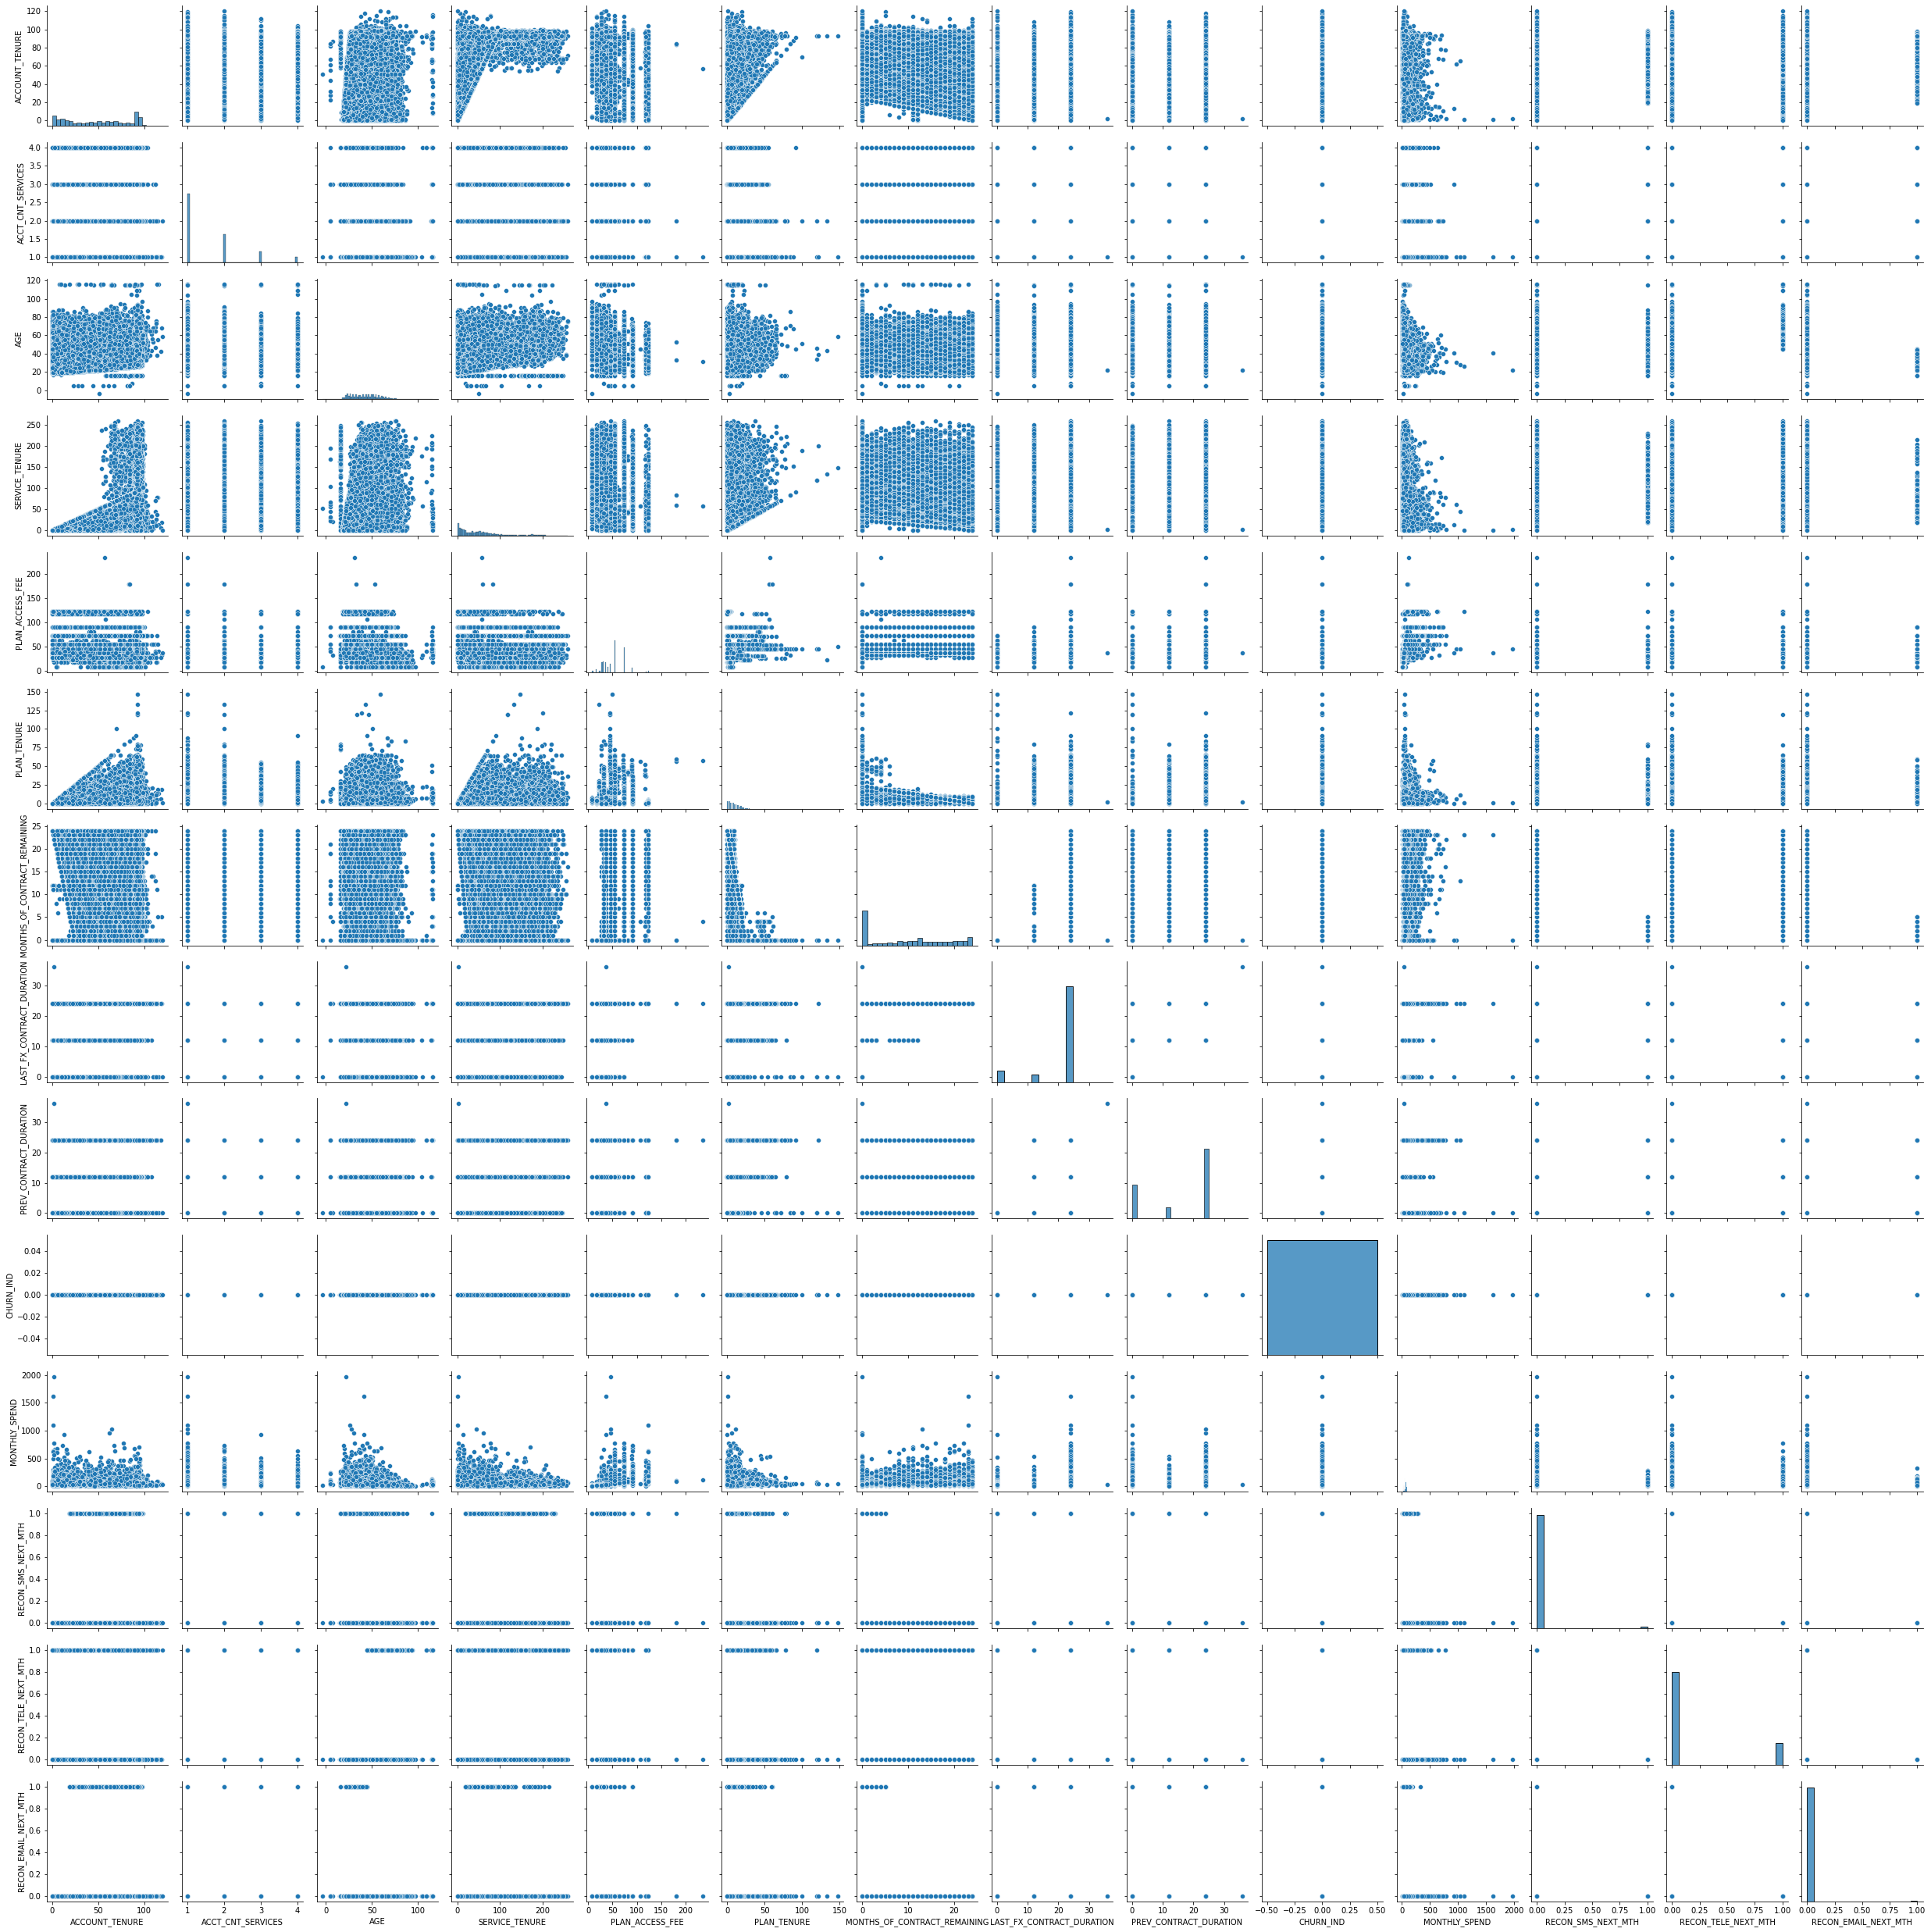

In [46]:
# Visualise the given data using a pairplot, excluding CUST_ID. 
sns.pairplot(churn.iloc[:,1:])

In [47]:
# Check the correlation of all columns in the dataframe
churn.iloc[:,1:].corr()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
ACCOUNT_TENURE,1.000000,0.203876,0.228927,0.785748,-0.082719,0.198149,-0.134346,0.169450,0.513201,NaN,-0.057773,0.027119,0.057276,0.021792
ACCT_CNT_SERVICES,0.203876,1.000000,0.158722,0.073938,-0.007027,-0.019048,-0.004110,0.008702,0.032735,NaN,-0.021027,-0.021703,0.100096,-0.009348
AGE,0.228927,0.158722,1.000000,0.236311,-0.378904,0.072699,-0.222861,-0.165191,-0.020187,NaN,-0.265816,-0.044429,0.434718,-0.046446
SERVICE_TENURE,0.785748,0.073938,0.236311,1.000000,-0.082896,0.177763,-0.136382,0.120820,0.412735,NaN,-0.061484,0.026324,0.050852,0.016902
PLAN_ACCESS_FEE,-0.082719,-0.007027,-0.378904,-0.082896,1.000000,-0.102997,0.503366,0.397494,0.160218,NaN,0.551365,-0.031203,-0.124343,-0.014458
PLAN_TENURE,0.198149,-0.019048,0.072699,0.177763,-0.102997,1.000000,-0.438847,0.066858,0.109616,NaN,-0.028220,0.092105,-0.011172,0.066236
MONTHS_OF_CONTRACT_REMAINING,-0.134346,-0.004110,-0.222861,-0.136382,0.503366,-0.438847,1.000000,0.482434,0.082085,NaN,0.270927,-0.099225,-0.013939,-0.067899
LAST_FX_CONTRACT_DURATION,0.169450,0.008702,-0.165191,0.120820,0.397494,0.066858,0.482434,1.000000,0.510539,NaN,0.248200,0.001324,-0.022215,0.011848
PREV_CONTRACT_DURATION,0.513201,0.032735,-0.020187,0.412735,0.160218,0.109616,0.082085,0.510539,1.000000,NaN,0.096054,0.010125,0.008188,0.009172
CHURN_IND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is clear from the plots above that:
* **ACCOUNT_TENURE & SERVICE_TENURE** are highly correlated
* **ACCOUNT_TENURE & PREV_CONTRACT_DURATION** are moderately correlated
*  **SERVICE_TENURE & PREV_CONTRACT_DURATION** are moderately correlated
* **MONTHS_OF_CONTRACT_REMAINING & PLAN_ACCESS_FEE** are moderately correlated
* **MONTHLY_SPEND & PLAN_ACCESS_FEE** are moderately correlated

**LOGISTIC REGRESSION**

Since we saw before that there is a strong correlation between **ACCOUNT_TENURE & SERVICE_TENURE**. We can now remove **SERVICE_TENURE** because **ACCOUNT_TENURE** will take care of the association.

In [49]:
# Split your data into training(70%) and testing data (30%) and use random_state=1
train, test = train_test_split(churn, test_size=0.3 , random_state=1)
print(train.shape)
print(test.shape)

(19856, 21)
(8510, 21)


In [50]:
# Getting input data and targets for building prediction model
X_train = train.drop(['CUST_ID','SERVICE_TENURE'], axis=1)
y_train = train['CUST_ID']
X_test = test.drop(['CUST_ID', 'SERVICE_TENURE'], axis=1)
y_test = test['CUST_ID']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_train.head())
print(y_train.head())

X_train shape:  (19856, 19)
y_train shape:  (19856,)
X_test shape:  (8510, 19)
y_test shape:  (8510,)
       ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE             CFU  \
INDEX                                                            
20965               0                  1  19.0        CONSUMER   
29932               3                  1  35.0        CONSUMER   
40274              96                  3  51.0  SMALL BUSINESS   
22119              58                  1  26.0  SMALL BUSINESS   
9060                1                  1  67.0        CONSUMER   

       PLAN_ACCESS_FEE BYO_PLAN_STATUS  PLAN_TENURE  \
INDEX                                                 
20965           118.18         NON BYO            0   
29932            45.45             BYO            3   
40274            72.72         NON BYO           12   
22119            72.72         NON BYO           12   
9060             72.72         NON BYO            1   

       MONTHS_OF_CONTRACT_REMAINING  LAST_FX_CONT

In [54]:
# Training Logistic Regression model
model = LogisticRegression()

In [57]:
model.fit(X_train, y_train)

ValueError: could not convert string to float: 'CONSUMER'

In [ ]:
# Doing predictions on train and test set
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)